In [182]:
import pandas as pd
import numpy as np
import seaborn as sns
import rdkit
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs
#from mordred import Calculator, descriptors
from rdkit.Chem import MACCSkeys
from rdkit.Chem import rdFingerprintGenerator
import matplotlib.pyplot as plt


from sklearn import svm, ensemble, metrics, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import auc, accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix


In [2]:
df = pd.read_csv("pIC50.csv")
df

,Unnamed: 0,cid,smiles,bioactivity,type,value (nM),pIC50
0,0,118159240,CC(=O)N1CCc2nc(N3CCC(C(=O)c4cc(Cl)ccc4F)CC3)c(...,Active,IC50,0.0138,10.860121
1,1,118180377,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CN(C(=...,Active,IC50,0.0138,10.860121
2,2,118180376,CC(=O)N1CCc2nc(N3CCC(Oc4ccc(F)cc4F)[C@H](F)C3)...,Active,IC50,0.0378,10.422508
3,3,118180374,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(CN...,Active,IC50,0.0626,10.203426
4,4,127024467,Cc1nccc2nc(NC3CC3)c(N3CCC(Cc4ccc(F)cc4F)CC3)nc...,Active,IC50,2.0000,8.698970
...,...,...,...,...,...,...,...
401,401,118159281,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(C(...,Inactive,IC50,340200.0000,3.468266
402,402,118159155,COc1cccc(S(=O)(=O)C2CCN(c3nc4c(nc3NC(C)C)CCN(C...,Inactive,IC50,341500.0000,3.466609
403,403,118159118,CC(=O)N1CCc2nc(N3CCN(Cc4ccc(C#N)cc4F)CC3)c(NC(...,Inactive,IC50,362900.0000,3.440213
404,404,118159228,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(C(...,Inactive,IC50,391000.0000,3.407823


In [3]:
#from sklearn.datasets import load_iris

In [4]:
#iris = load_iris()
#
#iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
#iris_df.head()
#iris_df.shape
#

In [5]:
#iris_X = np.array(iris_df)
#iris_X

In [6]:
    #iris_df['target'] = iris.target
    #iris_y = np.array(iris_df['target'])
    #iris_y.shape

<Figure size 2000x2000 with 0 Axes>

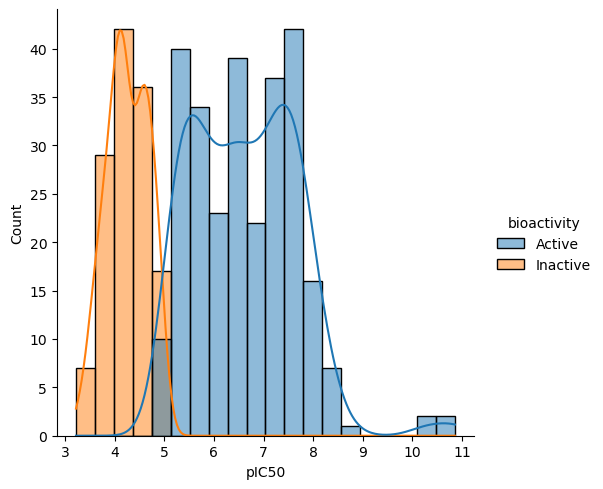

In [7]:
plt.figure(figsize=(20, 20))

sns.displot(df, bins=20, x='pIC50', hue='bioactivity', kde=True)
plt.show()

In [8]:
df2 = df[["cid", "smiles", "pIC50"]]
df2

,cid,smiles,pIC50
0,118159240,CC(=O)N1CCc2nc(N3CCC(C(=O)c4cc(Cl)ccc4F)CC3)c(...,10.860121
1,118180377,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CN(C(=...,10.860121
2,118180376,CC(=O)N1CCc2nc(N3CCC(Oc4ccc(F)cc4F)[C@H](F)C3)...,10.422508
3,118180374,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(CN...,10.203426
4,127024467,Cc1nccc2nc(NC3CC3)c(N3CCC(Cc4ccc(F)cc4F)CC3)nc...,8.698970
...,...,...,...
401,118159281,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(C(...,3.468266
402,118159155,COc1cccc(S(=O)(=O)C2CCN(c3nc4c(nc3NC(C)C)CCN(C...,3.466609
403,118159118,CC(=O)N1CCc2nc(N3CCN(Cc4ccc(C#N)cc4F)CC3)c(NC(...,3.440213
404,118159228,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(C(...,3.407823


In [9]:
df2["activity_label"] = np.zeros(len(df2))

df2.loc[df2[df2.pIC50 >= 5].index, "activity_label"] = 1.0

print("Number of active molecules:", int(df2.activity_label.sum()))
print("Number of inactive molecules:", len(df2) - int(df2.activity_label.sum()))

df

Number of active molecules: 275
Number of inactive molecules: 131


C:\Users\supak\AppData\Local\Temp\ipykernel_9248\901482849.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["activity_label"] = np.zeros(len(df2))


,Unnamed: 0,cid,smiles,bioactivity,type,value (nM),pIC50
0,0,118159240,CC(=O)N1CCc2nc(N3CCC(C(=O)c4cc(Cl)ccc4F)CC3)c(...,Active,IC50,0.0138,10.860121
1,1,118180377,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CN(C(=...,Active,IC50,0.0138,10.860121
2,2,118180376,CC(=O)N1CCc2nc(N3CCC(Oc4ccc(F)cc4F)[C@H](F)C3)...,Active,IC50,0.0378,10.422508
3,3,118180374,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(CN...,Active,IC50,0.0626,10.203426
4,4,127024467,Cc1nccc2nc(NC3CC3)c(N3CCC(Cc4ccc(F)cc4F)CC3)nc...,Active,IC50,2.0000,8.698970
...,...,...,...,...,...,...,...
401,401,118159281,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(C(...,Inactive,IC50,340200.0000,3.468266
402,402,118159155,COc1cccc(S(=O)(=O)C2CCN(c3nc4c(nc3NC(C)C)CCN(C...,Inactive,IC50,341500.0000,3.466609
403,403,118159118,CC(=O)N1CCc2nc(N3CCN(Cc4ccc(C#N)cc4F)CC3)c(NC(...,Inactive,IC50,362900.0000,3.440213
404,404,118159228,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(C(...,Inactive,IC50,391000.0000,3.407823


Create Fingerprint

In [10]:
def fingerprints(smiles, method="maccs", n_bits=2048):

    # convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=n_bits)
        return np.array(fpg.GetFingerprint(mol))
    if method == "morgan4":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=4, fpSize=n_bits)
        return np.array(fpg.GetFingerprint(mol))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [11]:
compound_df = df2.copy()

compound_df["fp"] = compound_df["smiles"].apply(fingerprints)
compound_df

,cid,smiles,pIC50,activity_label,fp
0,118159240,CC(=O)N1CCc2nc(N3CCC(C(=O)c4cc(Cl)ccc4F)CC3)c(...,10.860121,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,118180377,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CN(C(=...,10.860121,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,118180376,CC(=O)N1CCc2nc(N3CCC(Oc4ccc(F)cc4F)[C@H](F)C3)...,10.422508,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,118180374,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(CN...,10.203426,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,127024467,Cc1nccc2nc(NC3CC3)c(N3CCC(Cc4ccc(F)cc4F)CC3)nc...,8.698970,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...
401,118159281,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(C(...,3.468266,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
402,118159155,COc1cccc(S(=O)(=O)C2CCN(c3nc4c(nc3NC(C)C)CCN(C...,3.466609,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
403,118159118,CC(=O)N1CCc2nc(N3CCN(Cc4ccc(C#N)cc4F)CC3)c(NC(...,3.440213,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
404,118159228,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(C(...,3.407823,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


ML Functions for Fingerprint

In [12]:
#Plot Data
def plot_curve_functions(models, test_x, test_y):
    
    fig, ax = plt.subplots()
    
    
    #Loop iterates model list
    for model in models:
        
        #Select model
        ml_model = model["model"]
        
        #Predict test probability
        test_prob = ml_model.predict_proba(test_x)[:, 1]
        
        #Predict class on test set
        test_pred = ml_model.predict(test_x)
        
        #Compute False/True postitive rate
        fpr, tpr, thresholds = metrics.roc_curve(test_y, test_prob)
        
        #Calculate AUC
        auc = roc_auc_score(test_y, test_prob)
        
        ax.plot(fpr, tpr, label=(f"{model['label']} AUC area = {auc:.5f}"))
    
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")

    #if save_png:
        #fig.savefig(dpi=300, bbox_inches="tight", transparent=True)
    #return fig

In [13]:
def model_performance(ml_model, test_x, test_y, verbose=True):
    
    #Predict probability on test set
    test_prob = ml_model.predict_proba(test_x)[:, 1]
    
    #Predict class on test set
    test_pred = ml_model.predict(test_x)
    
    #Performance of test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)#, average='macro') # In case of Multi class, change a binary to micro, macro, weighted or None. pos_label is ignored
    spec = recall_score(test_y, test_pred, pos_label=0)#, average='macro)
    auc = roc_auc_score(test_y, test_prob)#,multi_class='ovr') # in case of Multi class, put function "multi_class = ovr or ovo"
    cm = confusion_matrix(test_y, test_pred)
    
    if verbose:
        print(f"Accuracy: {accuracy:.5f}")
        print(f"Sensitivity: {sens:.5f}")
        print(f"Specificity: {spec:.5f}")
        print(f"AUC: {auc:.5f}")
        print(f"Confusion Matrix: {cm}")

    return accuracy, sens, spec, auc, cm

In [14]:
def model_training_and_validation(ml_model, name, splits, verbose=True):

    train_x, test_x, train_y, test_y = splits

    #Fit model
    ml_model.fit(train_x, train_y)

    #Calculate performance results
    accuracy, sens, spec, auc, cm = model_performance(ml_model, test_x, test_y, verbose)
    
    sns.heatmap(cm, annot=True)
    plt.xlabel('predicted')
    plt.ylabel('Truth')
    
    return accuracy, sens, spec, auc, cm

Split Data

In [15]:
fp_to_model = compound_df.fp.tolist()
label_to_model = compound_df.activity_label.tolist()


(static_train_x, 
 static_test_x, 
 static_train_y,
 static_test_y) = train_test_split(fp_to_model, label_to_model, 
                                   test_size=0.2, random_state=42)

splits = [static_train_x, static_test_x, static_train_y, static_test_y]

print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))


Training data size: 324
Test data size: 82


Random Forest

In [16]:
param = {
    "n_estimators": 40,  # number of trees to grows
    "criterion": "entropy",  # cost function to be optimized for a split
}
model_RF = RandomForestClassifier(**param)

Accuracy: 0.96341
Sensitivity: 1.00000
Specificity: 0.87500
AUC: 0.99928
Confusion Matrix: [[21  3]
 [ 0 58]]


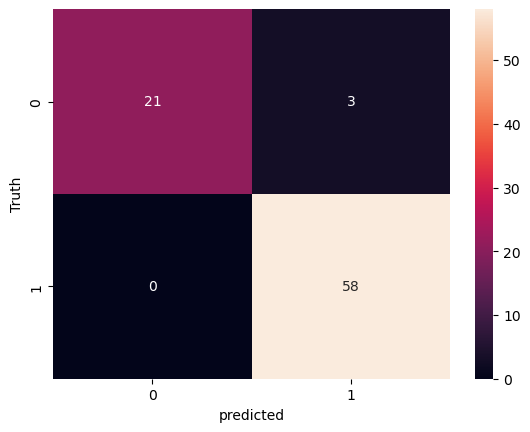

In [17]:
performance_measures = model_training_and_validation(model_RF, "RF", splits)

In [18]:
#feature_iris = pd.Series(model_RF.feature_importances_, index=compound_df.fp).sort_values(ascending=False)
#feature_iris

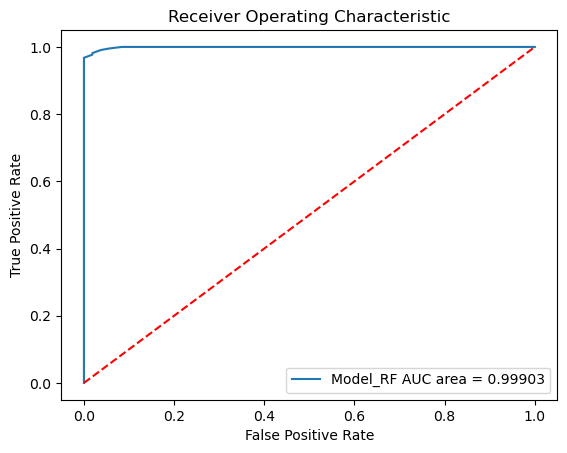

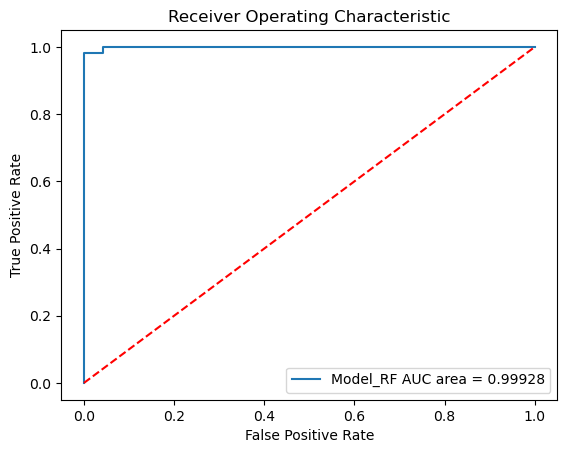

In [19]:
models = [{"label": "Model_RF", "model": model_RF}]

# Plot roc curve
plot_curve_functions(models, static_train_x, static_train_y)
plot_curve_functions(models, static_test_x, static_test_y)

SVM

Accuracy: 0.96341
Sensitivity: 0.94828
Specificity: 1.00000
AUC: 0.99353
Confusion Matrix: [[24  0]
 [ 3 55]]


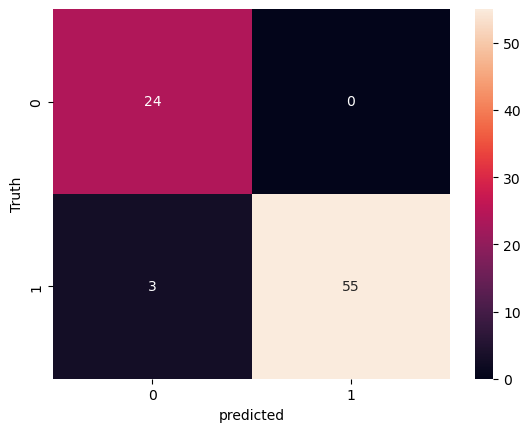

In [20]:
model_SVM = svm.SVC(kernel="linear", C=1, gamma=0.1, probability=True)

# Fit model on single split
performance_measures = model_training_and_validation(model_SVM, "SVM", splits)

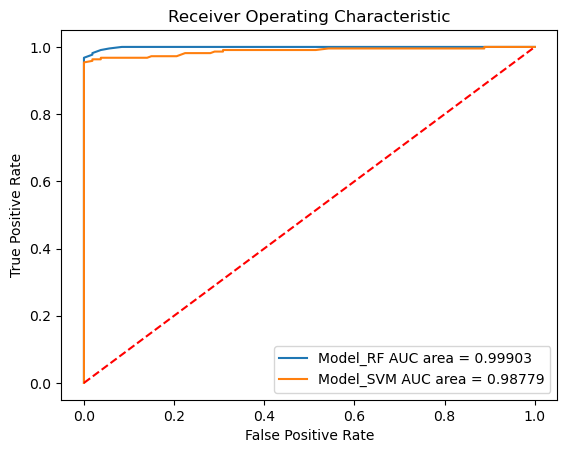

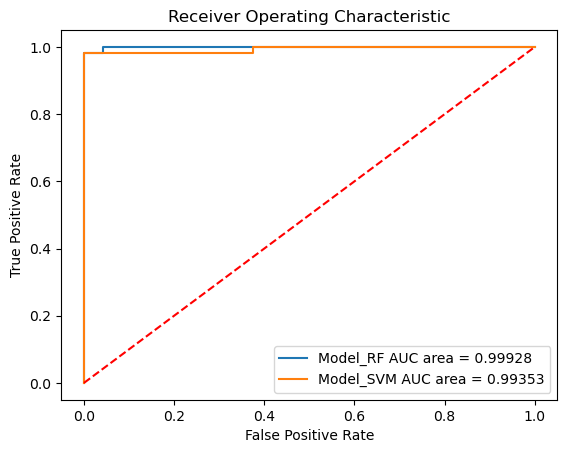

In [21]:
models.append({"label": "Model_SVM", "model": model_SVM})

# Plot roc curve
plot_curve_functions(models, static_train_x, static_train_y)
plot_curve_functions(models, static_test_x, static_test_y)

Gradient Boosting

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

Accuracy: 0.95122
Sensitivity: 0.96552
Specificity: 0.91667
AUC: 0.98922
Confusion Matrix: [[22  2]
 [ 2 56]]


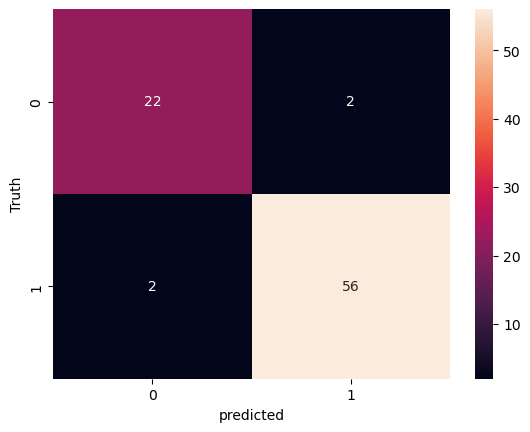

In [23]:
model_GB = GradientBoostingClassifier(n_estimators=40,
                                     learning_rate=0.1,
                                     criterion='friedman_mse',
                                     max_depth=1)

performance_measures = model_training_and_validation(model_GB, "GB", splits)

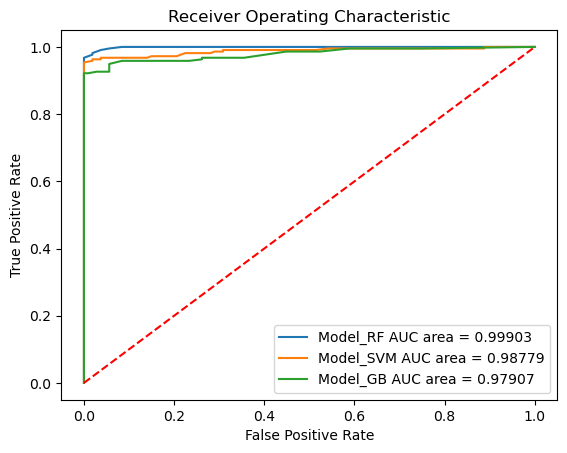

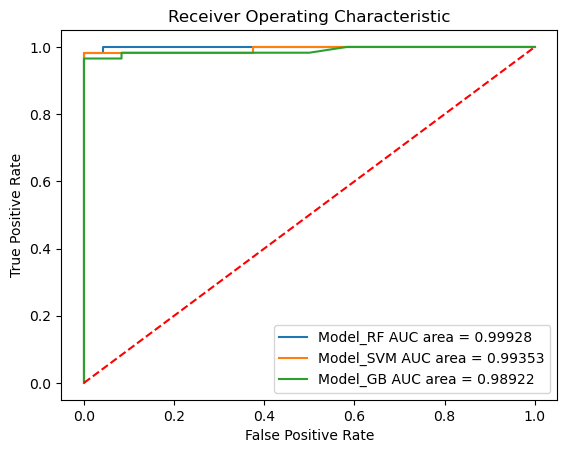

In [24]:
models.append({"label": "Model_GB", "model": model_GB})

plot_curve_functions(models, static_train_x, static_train_y)
plot_curve_functions(models, static_test_x, static_test_y)

ANN

Accuracy: 0.96341
Sensitivity: 0.98276
Specificity: 0.91667
AUC: 0.96875
Confusion Matrix: [[22  2]
 [ 1 57]]


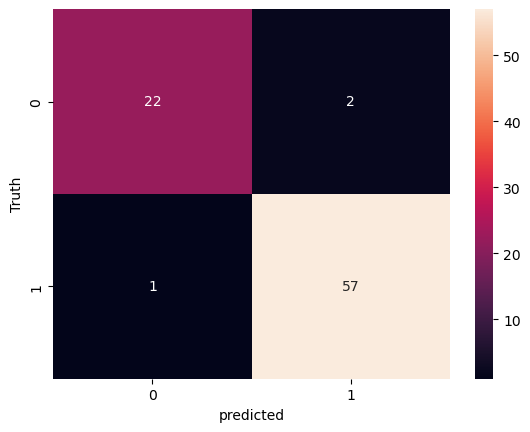

In [25]:
#Specify model
model_ANN = MLPClassifier(hidden_layer_sizes=(3, ), activation='identity',
                          solver='lbfgs', alpha=0.0001, max_iter=400)

# Fit model on single split
performance_measures = model_training_and_validation(model_ANN, "ANN", splits)

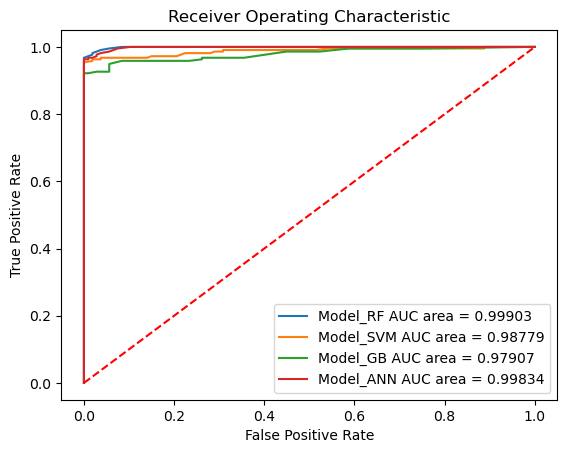

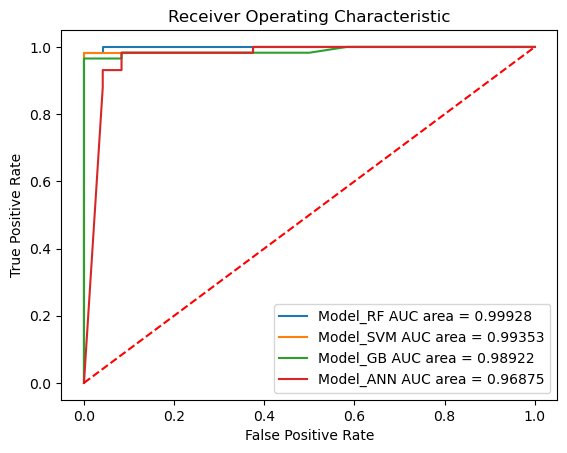

In [26]:
# Append ANN model
models.append({"label": "Model_ANN", "model": model_ANN})

# Plot roc curve
plot_curve_functions(models, static_train_x, static_train_y)
plot_curve_functions(models, static_test_x, static_test_y)

Classification Using Molecular Features

In [27]:
df2

,cid,smiles,pIC50,activity_label
0,118159240,CC(=O)N1CCc2nc(N3CCC(C(=O)c4cc(Cl)ccc4F)CC3)c(...,10.860121,1.0
1,118180377,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CN(C(=...,10.860121,1.0
2,118180376,CC(=O)N1CCc2nc(N3CCC(Oc4ccc(F)cc4F)[C@H](F)C3)...,10.422508,1.0
3,118180374,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(CN...,10.203426,1.0
4,127024467,Cc1nccc2nc(NC3CC3)c(N3CCC(Cc4ccc(F)cc4F)CC3)nc...,8.698970,1.0
...,...,...,...,...
401,118159281,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(C(...,3.468266,0.0
402,118159155,COc1cccc(S(=O)(=O)C2CCN(c3nc4c(nc3NC(C)C)CCN(C...,3.466609,0.0
403,118159118,CC(=O)N1CCc2nc(N3CCN(Cc4ccc(C#N)cc4F)CC3)c(NC(...,3.440213,0.0
404,118159228,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(C(...,3.407823,0.0


In [28]:
smile = [Chem.MolFromSmiles(i) for i in df2.smiles]
mol = [m for m in smile]
len(mol)

406

In [29]:
print(len(Descriptors._descList))
print(Descriptors._descList[:5])

209
[('MaxAbsEStateIndex', <function MaxAbsEStateIndex at 0x00000206B1178790>), ('MaxEStateIndex', <function MaxEStateIndex at 0x00000206B1178670>), ('MinAbsEStateIndex', <function MinAbsEStateIndex at 0x00000206B1178820>), ('MinEStateIndex', <function MinEStateIndex at 0x00000206B1178700>), ('qed', <function qed at 0x00000206B117B5B0>)]


In [110]:
descriptors = [Descriptors.CalcMolDescriptors(i) for i in mol]
rdkit_gpr6 = pd.DataFrame(descriptors)
rdkit_gpr6

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,14.187820,14.187820,0.034977,-0.532030,0.658737,473.980,444.748,473.199381,176,0,...,0,0,0,0,0,0,0,0,0,0
1,14.018710,14.018710,0.040537,-0.692270,0.679405,488.583,454.311,488.271131,190,0,...,0,0,0,0,0,0,0,0,0,1
2,15.077880,15.077880,0.007235,-1.401722,0.732420,463.504,435.280,463.219510,178,0,...,0,0,0,0,0,0,0,0,0,0
3,14.027118,14.027118,0.103907,-0.662901,0.619150,502.610,466.322,502.286781,196,0,...,0,0,0,0,0,0,0,0,0,0
4,14.030648,14.030648,0.373029,-5.083333,0.440062,523.506,497.298,523.200666,198,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,13.980299,13.980299,0.084153,-0.679987,0.688873,471.552,440.304,471.244582,182,0,...,0,0,0,0,0,0,0,0,0,0
402,13.250627,13.250627,0.029579,-3.463023,0.663173,487.626,454.362,487.225326,184,0,...,0,0,1,0,0,0,0,0,0,0
403,14.306601,14.306601,0.055294,-0.333280,0.747351,451.550,421.310,451.249587,174,0,...,0,0,0,0,0,0,0,0,0,0
404,14.017818,14.017818,0.082053,-0.681796,0.663656,500.594,466.322,500.271131,194,0,...,0,0,0,0,0,0,0,0,0,1


In [31]:
rdkit_gpr6.describe()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
count,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.0,...,406.000000,406.000000,406.000000,406.0,406.0,406.0,406.0,406.000000,406.000000,406.000000
mean,13.407435,13.407435,0.146775,-2.906237,0.551806,490.560377,465.303273,490.068246,181.921182,0.0,...,0.007389,0.068966,0.019704,0.0,0.0,0.0,0.0,0.022167,0.022167,0.054187
std,1.594267,1.594267,0.162150,2.097198,0.142109,77.633891,74.900296,77.514098,30.455532,0.0,...,0.085748,0.253708,0.139154,0.0,0.0,0.0,0.0,0.147410,0.163303,0.226666
min,4.871601,4.871601,0.000000,-5.083333,0.243006,253.308000,246.252000,252.997968,82.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
25%,13.003812,13.003812,0.040100,-5.083333,0.434120,457.531250,428.293000,457.233928,172.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
50%,13.966414,13.966414,0.082684,-3.226666,0.554611,502.816000,472.048500,502.228169,190.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
75%,14.176661,14.176661,0.202477,-0.682752,0.678792,538.844000,513.289750,538.190170,198.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
max,15.248740,15.248740,0.786402,0.716349,0.802254,656.641000,629.821000,656.248264,248.000000,0.0,...,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,1.000000,2.000000,1.000000


In [112]:
df_descriptor = df2.copy()
df_dataset = df_descriptor[['activity_label']].join(rdkit_gpr6)
df_dataset

,activity_label,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,1.0,14.187820,14.187820,0.034977,-0.532030,0.658737,473.980,444.748,473.199381,176,...,0,0,0,0,0,0,0,0,0,0
1,1.0,14.018710,14.018710,0.040537,-0.692270,0.679405,488.583,454.311,488.271131,190,...,0,0,0,0,0,0,0,0,0,1
2,1.0,15.077880,15.077880,0.007235,-1.401722,0.732420,463.504,435.280,463.219510,178,...,0,0,0,0,0,0,0,0,0,0
3,1.0,14.027118,14.027118,0.103907,-0.662901,0.619150,502.610,466.322,502.286781,196,...,0,0,0,0,0,0,0,0,0,0
4,1.0,14.030648,14.030648,0.373029,-5.083333,0.440062,523.506,497.298,523.200666,198,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,0.0,13.980299,13.980299,0.084153,-0.679987,0.688873,471.552,440.304,471.244582,182,...,0,0,0,0,0,0,0,0,0,0
402,0.0,13.250627,13.250627,0.029579,-3.463023,0.663173,487.626,454.362,487.225326,184,...,0,0,1,0,0,0,0,0,0,0
403,0.0,14.306601,14.306601,0.055294,-0.333280,0.747351,451.550,421.310,451.249587,174,...,0,0,0,0,0,0,0,0,0,0
404,0.0,14.017818,14.017818,0.082053,-0.681796,0.663656,500.594,466.322,500.271131,194,...,0,0,0,0,0,0,0,0,0,1


Split Train Test set

In [346]:
(feature_train_x, 
 feature_test_x, 
 feature_train_y,
 feature_test_y) = train_test_split(df_dataset.drop(['activity_label'], axis=1).values, 
                                    df_dataset['activity_label'].values, 
                                   test_size=0.2, shuffle=True)

splits_feature = [feature_train_x, feature_test_x, feature_train_y, feature_test_y]

print("Training data size:", len(feature_train_x))
print("Test data size:", len(feature_test_x))
print(feature_train_x.shape)
print(feature_train_y.shape)


Training data size: 324
Test data size: 82
(324, 209)
(324,)


Standardization

In [347]:
from sklearn import preprocessing

In [348]:
scaler = preprocessing.StandardScaler()
scaler.fit(feature_train_x)

sd_train_x = scaler.transform(feature_train_x)
sd_train_x

array([[ 0.40570656,  0.40570656, -0.48662361, ..., -0.15911146,
         5.60721018,  4.12310563],
       [-0.07072505, -0.07072505, -0.72974414, ..., -0.15911146,
        -0.14195469, -0.24253563],
       [ 0.42884597,  0.42884597, -0.70724511, ..., -0.15911146,
        -0.14195469, -0.24253563],
       ...,
       [ 0.3888488 ,  0.3888488 , -0.71062446, ..., -0.15911146,
        -0.14195469,  4.12310563],
       [ 0.64809831,  0.64809831, -0.77913519, ..., -0.15911146,
        -0.14195469, -0.24253563],
       [ 0.42031079,  0.42031079, -0.66857421, ..., -0.15911146,
        -0.14195469,  4.12310563]])

In [349]:
sd_test_x = scaler.transform(feature_test_x)
sd_test_x

array([[-0.11486005, -0.11486005, -0.76541372, ..., -0.15911146,
        -0.14195469, -0.24253563],
       [ 0.42222655,  0.42222655,  0.98661425, ..., -0.15911146,
        -0.14195469, -0.24253563],
       [ 0.37164342,  0.37164342, -0.80875687, ..., -0.15911146,
        -0.14195469, -0.24253563],
       ...,
       [ 0.31650679,  0.31650679, -0.71910967, ..., -0.15911146,
        -0.14195469, -0.24253563],
       [-0.08342559, -0.08342559, -0.82135087, ..., -0.15911146,
        -0.14195469, -0.24253563],
       [ 0.37895978,  0.37895978,  1.24144683, ..., -0.15911146,
        -0.14195469, -0.24253563]])

In [350]:
df_sd_train_x = pd.DataFrame(sd_train_x, columns=rdkit_gpr6.columns)
df_sd_train_x.describe()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
count,3.240000e+02,3.240000e+02,3.240000e+02,3.240000e+02,3.240000e+02,3.240000e+02,3.240000e+02,3.240000e+02,3.240000e+02,324.0,...,3.240000e+02,3.240000e+02,3.240000e+02,324.0,324.0,324.0,324.0,3.240000e+02,3.240000e+02,3.240000e+02
mean,-8.558312e-15,-8.558312e-15,1.864078e-16,3.004455e-15,-8.909197e-16,-6.469448e-16,5.104285e-15,4.210624e-15,-1.727014e-16,0.0,...,-1.370646e-17,7.675616e-17,7.401487e-17,0.0,0.0,0.0,0.0,-3.563679e-17,5.482583e-17,6.304970e-17
std,1.001547e+00,1.001547e+00,1.001547e+00,1.001547e+00,1.001547e+00,1.001547e+00,1.001547e+00,1.001547e+00,1.001547e+00,0.0,...,1.001547e+00,1.001547e+00,1.001547e+00,0.0,0.0,0.0,0.0,1.001547e+00,1.001547e+00,1.001547e+00
min,-5.392372e+00,-5.392372e+00,-9.044630e-01,-1.009867e+00,-2.090873e+00,-2.987724e+00,-2.871235e+00,-2.990327e+00,-3.187844e+00,0.0,...,-9.667365e-02,-2.764271e-01,-1.486002e-01,0.0,0.0,0.0,0.0,-1.591115e-01,-1.419547e-01,-2.425356e-01
25%,-2.715748e-01,-2.715748e-01,-6.447591e-01,-1.009867e+00,-8.364764e-01,-4.128810e-01,-4.977829e-01,-4.109632e-01,-2.657538e-01,0.0,...,-9.667365e-02,-2.764271e-01,-1.486002e-01,0.0,0.0,0.0,0.0,-1.591115e-01,-1.419547e-01,-2.425356e-01
50%,3.801039e-01,3.801039e-01,-4.083245e-01,-1.788440e-01,-1.913335e-02,1.380087e-01,7.118357e-02,1.349486e-01,2.537288e-01,0.0,...,-9.667365e-02,-2.764271e-01,-1.486002e-01,0.0,0.0,0.0,0.0,-1.591115e-01,-1.419547e-01,-2.425356e-01
75%,5.064893e-01,5.064893e-01,3.284618e-01,1.076753e+00,9.035986e-01,6.164057e-01,6.488069e-01,6.195223e-01,5.784054e-01,0.0,...,-9.667365e-02,-2.764271e-01,-1.486002e-01,0.0,0.0,0.0,0.0,-1.591115e-01,-1.419547e-01,-2.425356e-01
max,1.198307e+00,1.198307e+00,3.740695e+00,1.740163e+00,1.751290e+00,2.084310e+00,2.139375e+00,2.089307e+00,2.136853e+00,0.0,...,1.034408e+01,3.617590e+00,6.729466e+00,0.0,0.0,0.0,0.0,6.284903e+00,1.135638e+01,4.123106e+00


In [351]:
df_sd_test_x = pd.DataFrame(sd_test_x, columns=rdkit_gpr6.columns)
df_sd_test_x.describe()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
count,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.0,...,8.200000e+01,82.000000,82.000000,82.0,82.0,82.0,82.0,82.000000,82.000000,82.000000
mean,0.142923,0.142923,-0.185594,0.111129,0.151803,-0.098410,-0.103889,-0.097861,-0.042440,0.0,...,-9.667365e-02,-0.038987,-0.064721,0.0,0.0,0.0,0.0,-0.080526,-0.071843,-0.029578
std,1.053431,1.053431,0.747684,0.966665,0.864507,0.910756,0.910019,0.911741,0.942003,0.0,...,4.188957e-17,0.937516,0.759555,0.0,0.0,0.0,0.0,0.711622,0.634889,0.946185
min,-4.567644,-4.567644,-0.904463,-1.009867,-1.833048,-3.025784,-2.897445,-3.028539,-3.252779,0.0,...,-9.667365e-02,-0.276427,-0.148600,0.0,0.0,0.0,0.0,-0.159111,-0.141955,-0.242536
25%,0.222062,0.222062,-0.751965,-1.009867,-0.565319,-0.543173,-0.555561,-0.545287,-0.509261,0.0,...,-9.667365e-02,-0.276427,-0.148600,0.0,0.0,0.0,0.0,-0.159111,-0.141955,-0.242536
50%,0.396064,0.396064,-0.429332,0.185071,0.215672,0.100868,0.047757,0.103305,0.221261,0.0,...,-9.667365e-02,-0.276427,-0.148600,0.0,0.0,0.0,0.0,-0.159111,-0.141955,-0.242536
75%,0.569409,0.569409,0.054454,1.078862,0.814714,0.420137,0.416646,0.423332,0.448535,0.0,...,-9.667365e-02,-0.276427,-0.148600,0.0,0.0,0.0,0.0,-0.159111,-0.141955,-0.242536
max,1.129637,1.129637,2.227625,1.651919,1.592784,2.012701,2.139375,2.011197,1.552435,0.0,...,-9.667365e-02,3.617590,6.729466,0.0,0.0,0.0,0.0,6.284903,5.607210,4.123106


In [352]:
df_feature_train_y = pd.DataFrame(feature_train_y, columns=['activity_label'])
df_feature_test_y = pd.DataFrame(feature_test_y, columns=['activity_label'])

In [353]:
df_train_set = df_feature_train_y.join(df_sd_train_x)
df_train_set

,activity_label,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0.0,0.405707,0.405707,-0.486624,1.072449,-0.098125,0.157773,0.044763,0.160426,0.448535,...,-0.096674,-0.276427,-0.148600,0.0,0.0,0.0,0.0,-0.159111,5.607210,4.123106
1,0.0,-0.070725,-0.070725,-0.729744,-0.241566,0.795772,-0.057053,-0.164657,-0.055846,0.058923,...,-0.096674,-0.276427,6.729466,0.0,0.0,0.0,0.0,-0.159111,-0.141955,-0.242536
2,0.0,0.428846,0.428846,-0.707245,1.077138,0.578513,0.284964,0.150117,0.287604,0.578405,...,-0.096674,-0.276427,-0.148600,0.0,0.0,0.0,0.0,-0.159111,-0.141955,-0.242536
3,1.0,0.318030,0.318030,-0.384822,1.079926,1.013015,-1.174277,-1.190238,-1.173182,-0.980042,...,-0.096674,-0.276427,-0.148600,0.0,0.0,0.0,0.0,-0.159111,-0.141955,-0.242536
4,0.0,0.478759,0.478759,-0.117201,1.135716,0.862654,-0.070471,-0.165327,-0.068155,0.188793,...,-0.096674,-0.276427,-0.148600,0.0,0.0,0.0,0.0,-0.159111,-0.141955,-0.242536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,0.0,1.068108,1.068108,-0.617591,0.720006,1.510223,-0.768075,-0.835412,-0.766514,-0.525495,...,-0.096674,-0.276427,-0.148600,0.0,0.0,0.0,0.0,-0.159111,-0.141955,-0.242536
320,1.0,0.321270,0.321270,-0.343803,-1.009867,-0.453457,0.244801,0.293801,0.247975,0.318664,...,-0.096674,-0.276427,-0.148600,0.0,0.0,0.0,0.0,-0.159111,-0.141955,-0.242536
321,0.0,0.388849,0.388849,-0.710624,1.074807,1.139036,-0.222646,-0.323049,-0.220453,0.058923,...,-0.096674,-0.276427,-0.148600,0.0,0.0,0.0,0.0,-0.159111,-0.141955,4.123106
322,1.0,0.648098,0.648098,-0.779135,-1.009867,-1.736542,2.084310,2.067993,2.089307,2.136853,...,-0.096674,-0.276427,-0.148600,0.0,0.0,0.0,0.0,-0.159111,-0.141955,-0.242536


In [354]:
df_test_set = df_feature_test_y.join(df_sd_test_x)
df_test_set

,activity_label,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,1.0,-0.114860,-0.114860,-0.765414,-1.009867,-1.221670,2.012701,2.139375,2.011197,1.552435,...,-0.096674,3.617590,-0.148600,0.0,0.0,0.0,0.0,-0.159111,-0.141955,-0.242536
1,1.0,0.422227,0.422227,0.986614,1.142782,0.817755,-0.907936,-0.900951,-0.906657,-0.785236,...,-0.096674,-0.276427,-0.148600,0.0,0.0,0.0,0.0,-0.159111,-0.141955,-0.242536
2,0.0,0.371643,0.371643,-0.808757,-0.095167,0.059091,0.321111,0.333182,0.324466,0.448535,...,-0.096674,-0.276427,-0.148600,0.0,0.0,0.0,0.0,-0.159111,-0.141955,-0.242536
3,1.0,0.376641,0.376641,0.552014,0.208742,0.355141,-0.921125,-0.901385,-0.919527,-0.785236,...,-0.096674,-0.276427,-0.148600,0.0,0.0,0.0,0.0,-0.159111,-0.141955,-0.242536
4,0.0,0.642021,0.642021,-0.846471,1.203424,0.709811,0.082021,-0.046986,0.084397,0.383599,...,-0.096674,-0.276427,-0.148600,0.0,0.0,0.0,0.0,-0.159111,-0.141955,4.123106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,0.0,0.587429,0.587429,-0.592115,1.201069,1.132669,-0.438106,-0.546363,-0.436291,-0.135883,...,-0.096674,-0.276427,-0.148600,0.0,0.0,0.0,0.0,-0.159111,-0.141955,-0.242536
78,0.0,0.408015,0.408015,-0.630782,1.220823,1.494459,-0.736996,-0.816437,-0.741451,-0.655366,...,-0.096674,-0.276427,-0.148600,0.0,0.0,0.0,0.0,-0.159111,-0.141955,-0.242536
79,1.0,0.316507,0.316507,-0.719110,-1.009867,-0.453457,0.244801,0.293801,0.247975,0.318664,...,-0.096674,-0.276427,-0.148600,0.0,0.0,0.0,0.0,-0.159111,-0.141955,-0.242536
80,0.0,-0.083426,-0.083426,-0.821351,-0.275153,0.805592,-0.209546,-0.282998,-0.208397,-0.135883,...,-0.096674,-0.276427,6.729466,0.0,0.0,0.0,0.0,-0.159111,-0.141955,-0.242536


In [355]:
feature_name = np.array(df_sd_train_x.columns)
feature_name

array(['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex',
       'MinEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt',
       'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge',
       'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge',
       'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3',
       'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO',
       'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW',
       'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1',
       'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n',
       'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3',
       'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12',
       'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4',
       'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9',
       'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4',
 

UMAP plot (Fingerprint VS Features)

In [356]:
import umap.umap_ as umap
import umap.plot

In [357]:
umapper = umap.UMAP(n_neighbors=50, 
                    n_components=2,
                    metric='euclidean', 
                    random_state=412
                    )

In [358]:
umap_desc = umapper.fit_transform(df_sd_train_x)

In [359]:
umap_desc_x = pd.DataFrame(umap_desc[:, 0], columns = ['x'])
umap_desc_y = pd.DataFrame(umap_desc[:, 1], columns = ['y'])
activity_label = pd.DataFrame(df_train_set['activity_label'], columns = ['activity_label'])
plot_umap_desc = pd.concat([activity_label, umap_desc_x, umap_desc_y], axis = 1)
plot_umap_desc

,activity_label,x,y
0,0.0,-6.403624,18.295897
1,0.0,-5.225330,19.144758
2,0.0,-5.844766,17.955090
3,1.0,-4.038563,17.831055
4,0.0,-5.514918,18.111406
...,...,...,...
319,0.0,-4.450983,17.434052
320,1.0,12.348347,12.416035
321,0.0,-6.475824,17.898785
322,1.0,13.585659,13.083605


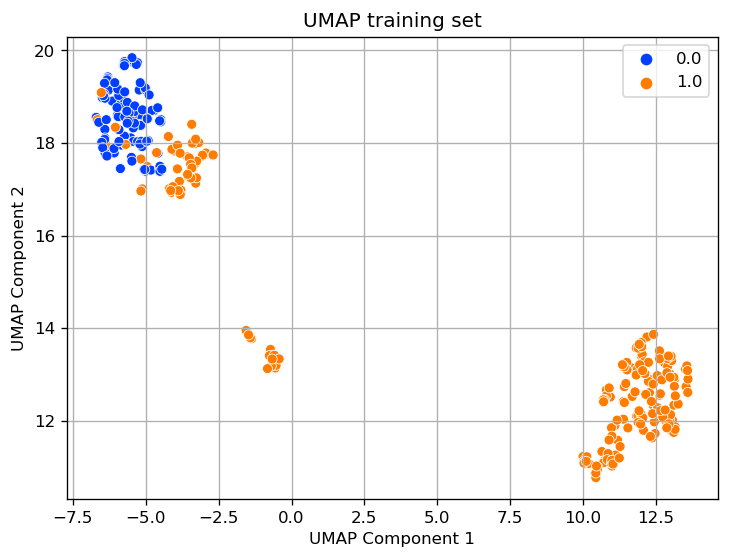

In [360]:
plt.figure(figsize = (7, 5), dpi=120)
sns.scatterplot(x='x', y='y', hue='activity_label', data=plot_umap_desc, palette='bright')
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.grid()
plt.legend()
plt.title('UMAP training set', fontsize=12)
plt.show()

ML function for features

In [361]:
def plot_curve_functions_feature(models, test_x, test_y):
    
    fig, ax = plt.subplots()
    
    
    #Loop iterates model list
    for model in models:
        
        #Select model
        ml_model = model["model"]
        
        #Predict test probability
        test_prob = ml_model.predict_proba(test_x)[:, 1]
        
        #Predict class on test set
        test_pred = ml_model.predict(test_x)
        
        #Compute False/True postitive rate
        fpr, tpr, thresholds = metrics.roc_curve(test_y, test_prob)
        
        #Calculate AUC
        auc = roc_auc_score(test_y, test_prob)
        
        ax.plot(fpr, tpr, label=(f"{model['label']} AUC area = {auc:.5f}"))
    
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")

In [362]:
def model_performance_feature(ml_model, test_x, test_y, verbose=True):
    
    #Predict probability on test set
    test_prob = ml_model.predict_proba(test_x)[:, 1]
    
    #Predict class on test set
    test_pred = ml_model.predict(test_x)
    
    #Performance of test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)#, average='macro') # In case of Multi class, change a binary to micro, macro, weighted or None. pos_label is ignored
    spec = recall_score(test_y, test_pred, pos_label=0)#, average='macro)
    auc = roc_auc_score(test_y, test_prob)#,multi_class='ovr') # in case of Multi class, put function "multi_class = ovr or ovo"
    cm = confusion_matrix(test_y, test_pred)
    
    if verbose:
        print(f"Accuracy: {accuracy:.5f}")
        print(f"Sensitivity: {sens:.5f}")
        print(f"Specificity: {spec:.5f}")
        print(f"AUC: {auc:.5f}")
        print(f"Confusion Matrix: {cm}")

    return accuracy, sens, spec, auc, cm

In [363]:
def model_training_and_validation_feature(ml_model, name, splits_training, verbose=True):

    train_x, test_x, train_y, test_y = splits_training

    #Fit model
    ml_model.fit(train_x, train_y)

    #Calculate performance results
    accuracy, sens, spec, auc, cm = model_performance_feature(ml_model, test_x, test_y, verbose)
    
    sns.heatmap(cm, annot=True)
    plt.xlabel('predicted')
    plt.ylabel('Truth')
    
    return accuracy, sens, spec, auc, cm

Random Forest (Features) with Boruta Feature Selection

In [364]:
from boruta import BorutaPy
import xgboost as xgb


rf = RandomForestClassifier()
gb = GradientBoostingClassifier()
ANN = MLPClassifier()
xgb = xgb.XGBClassifier()

In [365]:
from boruta import BorutaPy

feat_selector = BorutaPy(rf, random_state=42, verbose=2, max_iter=100, n_estimators=100, perc = 100)
feat_selector.fit(df_train_set.drop(['activity_label'], axis=1).values, df_train_set['activity_label'].values) #fit to initial train set, then apply selected train x, y again into functions

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	209
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	209
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	209
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	209
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	209
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	209
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	209
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	22
Tentative: 	78
Rejected: 	109
Iteration: 	9 / 100
Confirmed: 	22
Tentative: 	78
Rejected: 	109
Iteration: 	10 / 100
Confirmed: 	22
Tentative: 	78
Rejected: 	109
Iteration: 	11 / 100
Confirmed: 	22
Tentative: 	78
Rejected: 	109
Iteration: 	12 / 100
Confirmed: 	26
Tentative: 	74
Rejected: 	109
Iteration: 	13 / 100
Confirmed: 	26
Tentative: 	68
Rejected: 	115
Iteration: 	14 / 100
Confirmed: 	26
Tentative: 	68
Rejected: 	115
Iteration: 	15 / 100
Confirmed: 	26
Tentative: 	68
Rejected: 	115
Iteration: 	16 / 100
Confirmed: 	

BorutaPy(estimator=RandomForestClassifier(random_state=RandomState(MT19937) at 0x206CAC58140),
         n_estimators=100, random_state=RandomState(MT19937) at 0x206CAC58140,
         verbose=2)

In [366]:
feature_rank = list(zip(feature_name,
                    feat_selector.ranking_,
                    feat_selector.support_
                    ))

In [367]:
for feat in feature_rank:
    print('Feature: {:<30} Rank: {}, Keep: {}'.format(feat[0], feat[1], feat[2]))

Feature: MaxAbsEStateIndex              Rank: 3, Keep: False
Feature: MaxEStateIndex                 Rank: 3, Keep: False
Feature: MinAbsEStateIndex              Rank: 1, Keep: True
Feature: MinEStateIndex                 Rank: 1, Keep: True
Feature: qed                            Rank: 1, Keep: True
Feature: MolWt                          Rank: 7, Keep: False
Feature: HeavyAtomMolWt                 Rank: 19, Keep: False
Feature: ExactMolWt                     Rank: 19, Keep: False
Feature: NumValenceElectrons            Rank: 2, Keep: False
Feature: NumRadicalElectrons            Rank: 133, Keep: False
Feature: MaxPartialCharge               Rank: 1, Keep: True
Feature: MinPartialCharge               Rank: 23, Keep: False
Feature: MaxAbsPartialCharge            Rank: 36, Keep: False
Feature: MinAbsPartialCharge            Rank: 2, Keep: False
Feature: FpDensityMorgan1               Rank: 26, Keep: False
Feature: FpDensityMorgan2               Rank: 1, Keep: True
Feature: FpDensityMorg

In [368]:
selected_feature_train_x = feat_selector.transform(sd_train_x)
print(selected_feature_train_x.shape)
print(feature_train_y.shape)


(324, 36)
(324,)


Optimize Hyperparameter

In [369]:
import sklearn
import sklearn.model_selection
import optuna #optimize hyperparameter

In [370]:
def objective(trial):
    
    X, y = selected_feature_train_x, feature_train_y
    
    classifier_name = trial.suggest_categorical('classifier',['SVC', 'GradientBoosting', 'NeuralNetwork', 'RandomForest'])
    
    if classifier_name == 'SVC':
        C = trial.suggest_float('C', 1e-10, 1e10, log=True)
        kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf'])
        gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
        degree = trial.suggest_int('degree', 1, 3)
        
        classifier_obj = svm.SVC(C=C, kernel=kernel, gamma=gamma, degree=degree, probability=True)
        
    elif classifier_name == 'GradientBoosting':
        n_estimators = trial.suggest_int('n_estimators', 1, 100)
        criterion = trial.suggest_categorical('criterion', ['friedman_mse', 'squared_error'])
        
        classifier_obj = GradientBoostingClassifier(n_estimators=n_estimators, criterion=criterion)

    #elif classifier_name == 'XGBoost':
    #    objective = 'binary:logistic'
    #    booster = trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart'])
    #    lambda = trial.suggest_float('lambda', 1e-8, 1.0, log=True)
    #    alpha = trial.suggest_float('alpha', 1e-8, 1.0, log=True)
    #    max_depth = trial.suggest_int('max_depth', 2, 20, log=True)
    #    eta = trial.suggest_float('eta', 0, 1.0, log=True)
    #    
    #    classifier_obj = xgb.XGBClassifier(booster=booster, lambda=lambda, alpha=alpha, max_depth=max_depth, eta=eta)
        
    elif classifier_name == 'NeuralNetwork':
        solver = 'lbfgs'
        hidden_layer_sizes = trial.suggest_int('hidden_layer_sizes', 2, 100)
        activation = trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu'])
        alpha = trial.suggest_float('alpha', 1e-8, 1e8, log=True)
        learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive'])
        
        classifier_obj = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, alpha=alpha, learning_rate=learning_rate)
          
    else:
        max_depth = trial.suggest_int('max_depth', 2, 20, log=True)
        n_estimators = trial.suggest_int('n_estimators', 2, 100)
        #criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
        
        classifier_obj = sklearn.ensemble.RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators) #add n_estimators
        
    score = sklearn.model_selection.cross_val_score(classifier_obj, X, y, n_jobs=-1, cv=3)
    
    accuracy = score.mean()
        
    return accuracy


if __name__ == "__main__":
    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=12))
    study.optimize(objective, n_trials=100)
    print(study.best_trial)

[I 2023-08-29 19:38:13,567] A new study created in memory with name: no-name-c879aafe-0fd5-4e82-91e7-688ddd778664
[I 2023-08-29 19:38:13,603] Trial 0 finished with value: 0.6820987654320988 and parameters: {'classifier': 'GradientBoosting', 'n_estimators': 2, 'criterion': 'friedman_mse'}. Best is trial 0 with value: 0.6820987654320988.
[I 2023-08-29 19:38:13,883] Trial 1 finished with value: 0.9598765432098765 and parameters: {'classifier': 'GradientBoosting', 'n_estimators': 61, 'criterion': 'friedman_mse'}. Best is trial 1 with value: 0.9598765432098765.
[I 2023-08-29 19:38:14,039] Trial 2 finished with value: 0.9753086419753086 and parameters: {'classifier': 'NeuralNetwork', 'hidden_layer_sizes': 78, 'activation': 'logistic', 'alpha': 7.250505368165112e-07, 'learning_rate': 'invscaling'}. Best is trial 2 with value: 0.9753086419753086.
[I 2023-08-29 19:38:14,055] Trial 3 finished with value: 0.6820987654320988 and parameters: {'classifier': 'SVC', 'C': 0.0003559504327480527, 'kernel

FrozenTrial(number=5, state=TrialState.COMPLETE, values=[0.9783950617283951], datetime_start=datetime.datetime(2023, 8, 29, 19, 38, 14, 196170), datetime_complete=datetime.datetime(2023, 8, 29, 19, 38, 14, 320901), params={'classifier': 'NeuralNetwork', 'hidden_layer_sizes': 48, 'activation': 'tanh', 'alpha': 2.7959192342448827e-08, 'learning_rate': 'constant'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'classifier': CategoricalDistribution(choices=('SVC', 'GradientBoosting', 'NeuralNetwork', 'RandomForest')), 'hidden_layer_sizes': IntDistribution(high=100, log=False, low=2, step=1), 'activation': CategoricalDistribution(choices=('identity', 'logistic', 'tanh', 'relu')), 'alpha': FloatDistribution(high=100000000.0, log=True, low=1e-08, step=None), 'learning_rate': CategoricalDistribution(choices=('constant', 'invscaling', 'adaptive'))}, trial_id=5, value=None)


In [371]:
selected_feature_train_x.shape

(324, 36)

Train model using training set

Accuracy: 0.97840
Sensitivity: 0.96833
Specificity: 1.00000
AUC: 0.99236
Confusion Matrix: [[103   0]
 [  7 214]]


c:\Users\supak\anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


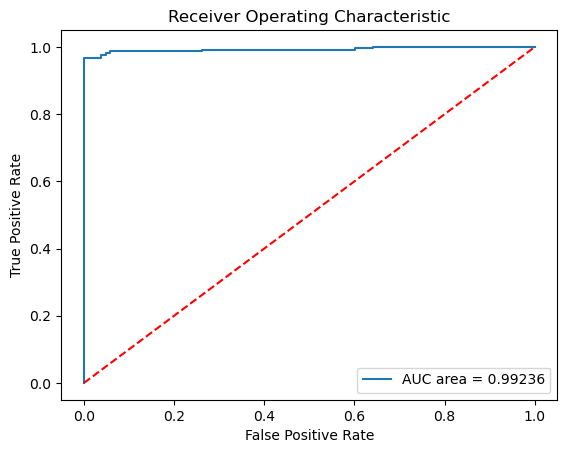

In [395]:
model_ANN = MLPClassifier(hidden_layer_sizes=48, activation='tanh', alpha=2.7959, learning_rate='constant')

model_ANN.fit(selected_feature_train_x, feature_train_y)

test_prob = model_ANN.predict_proba(selected_feature_train_x)[:, 1]
    
test_pred = model_ANN.predict(selected_feature_train_x)

accuracy = accuracy_score(feature_train_y, test_pred)
sens = recall_score(feature_train_y, test_pred)#, average='macro') # In case of Multi class, change a binary to micro, macro, weighted or None. pos_label is ignored
spec = recall_score(feature_train_y, test_pred, pos_label=0)#, average='macro)
auc = roc_auc_score(feature_train_y, test_prob)#,multi_class='ovr') # in case of Multi class, put function "multi_class = ovr or ovo"
cm = confusion_matrix(feature_train_y, test_pred)

print(f"Accuracy: {accuracy:.5f}")
print(f"Sensitivity: {sens:.5f}")
print(f"Specificity: {spec:.5f}")
print(f"AUC: {auc:.5f}")
print(f"Confusion Matrix: {cm}")

fig, ax = plt.subplots()
fpr, tpr, thresholds = metrics.roc_curve(feature_train_y, test_prob)
ax.plot(fpr, tpr, label=(f"AUC area = {auc:.5f}"))
ax.plot([0, 1], [0, 1], "r--")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("Receiver Operating Characteristic")
ax.legend(loc="lower right")

<Axes: >

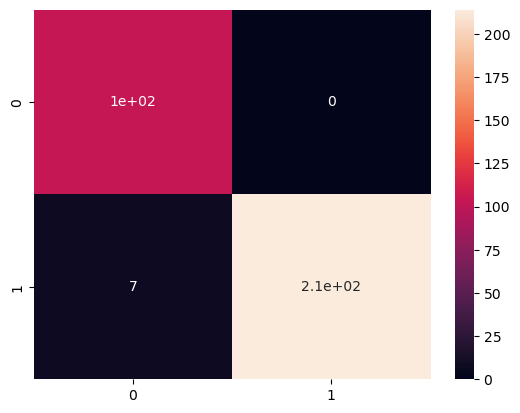

In [396]:
sns.heatmap(cm, annot=True)

Apply Standardized Test set to Boruta

In [397]:
df_test_set

,activity_label,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,1.0,-0.114860,-0.114860,-0.765414,-1.009867,-1.221670,2.012701,2.139375,2.011197,1.552435,...,-0.096674,3.617590,-0.148600,0.0,0.0,0.0,0.0,-0.159111,-0.141955,-0.242536
1,1.0,0.422227,0.422227,0.986614,1.142782,0.817755,-0.907936,-0.900951,-0.906657,-0.785236,...,-0.096674,-0.276427,-0.148600,0.0,0.0,0.0,0.0,-0.159111,-0.141955,-0.242536
2,0.0,0.371643,0.371643,-0.808757,-0.095167,0.059091,0.321111,0.333182,0.324466,0.448535,...,-0.096674,-0.276427,-0.148600,0.0,0.0,0.0,0.0,-0.159111,-0.141955,-0.242536
3,1.0,0.376641,0.376641,0.552014,0.208742,0.355141,-0.921125,-0.901385,-0.919527,-0.785236,...,-0.096674,-0.276427,-0.148600,0.0,0.0,0.0,0.0,-0.159111,-0.141955,-0.242536
4,0.0,0.642021,0.642021,-0.846471,1.203424,0.709811,0.082021,-0.046986,0.084397,0.383599,...,-0.096674,-0.276427,-0.148600,0.0,0.0,0.0,0.0,-0.159111,-0.141955,4.123106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,0.0,0.587429,0.587429,-0.592115,1.201069,1.132669,-0.438106,-0.546363,-0.436291,-0.135883,...,-0.096674,-0.276427,-0.148600,0.0,0.0,0.0,0.0,-0.159111,-0.141955,-0.242536
78,0.0,0.408015,0.408015,-0.630782,1.220823,1.494459,-0.736996,-0.816437,-0.741451,-0.655366,...,-0.096674,-0.276427,-0.148600,0.0,0.0,0.0,0.0,-0.159111,-0.141955,-0.242536
79,1.0,0.316507,0.316507,-0.719110,-1.009867,-0.453457,0.244801,0.293801,0.247975,0.318664,...,-0.096674,-0.276427,-0.148600,0.0,0.0,0.0,0.0,-0.159111,-0.141955,-0.242536
80,0.0,-0.083426,-0.083426,-0.821351,-0.275153,0.805592,-0.209546,-0.282998,-0.208397,-0.135883,...,-0.096674,-0.276427,6.729466,0.0,0.0,0.0,0.0,-0.159111,-0.141955,-0.242536


In [399]:
rf = RandomForestClassifier()

feat_selector_test = BorutaPy(rf, random_state=42, verbose=2, max_iter=100, n_estimators=100, perc = 100)
feat_selector_test.fit(df_test_set.drop(['activity_label'], axis=1).values, df_test_set['activity_label'].values)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	209
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	209
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	209
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	209
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	209
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	209
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	209
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	73
Rejected: 	136
Iteration: 	9 / 100
Confirmed: 	12
Tentative: 	61
Rejected: 	136
Iteration: 	10 / 100
Confirmed: 	12
Tentative: 	61
Rejected: 	136
Iteration: 	11 / 100
Confirmed: 	12
Tentative: 	61
Rejected: 	136
Iteration: 	12 / 100
Confirmed: 	15
Tentative: 	46
Rejected: 	148
Iteration: 	13 / 100
Confirmed: 	15
Tentative: 	46
Rejected: 	148
Iteration: 	14 / 100
Confirmed: 	15
Tentative: 	46
Rejected: 	148
Iteration: 	15 / 100
Confirmed: 	15
Tentative: 	46
Rejected: 	148
Iteration: 	16 / 100
Confirmed: 	1

BorutaPy(estimator=RandomForestClassifier(random_state=RandomState(MT19937) at 0x206CCDE1A40),
         n_estimators=100, random_state=RandomState(MT19937) at 0x206CCDE1A40,
         verbose=2)

In [400]:
feature_rank_test = list(zip(feature_name,
                    feat_selector_test.ranking_,
                    feat_selector_test.support_
                    ))

In [401]:
for feat in feature_rank_test:
    print('Feature: {:<30} Rank: {}, Keep: {}'.format(feat[0], feat[1], feat[2]))

Feature: MaxAbsEStateIndex              Rank: 38, Keep: False
Feature: MaxEStateIndex                 Rank: 76, Keep: False
Feature: MinAbsEStateIndex              Rank: 1, Keep: True
Feature: MinEStateIndex                 Rank: 31, Keep: False
Feature: qed                            Rank: 2, Keep: False
Feature: MolWt                          Rank: 51, Keep: False
Feature: HeavyAtomMolWt                 Rank: 34, Keep: False
Feature: ExactMolWt                     Rank: 57, Keep: False
Feature: NumValenceElectrons            Rank: 33, Keep: False
Feature: NumRadicalElectrons            Rank: 153, Keep: False
Feature: MaxPartialCharge               Rank: 19, Keep: False
Feature: MinPartialCharge               Rank: 1, Keep: True
Feature: MaxAbsPartialCharge            Rank: 11, Keep: False
Feature: MinAbsPartialCharge            Rank: 27, Keep: False
Feature: FpDensityMorgan1               Rank: 2, Keep: False
Feature: FpDensityMorgan2               Rank: 1, Keep: True
Feature: FpDens

In [402]:
selected_feature_test_x = feat_selector_test.transform(sd_test_x)
print(selected_feature_test_x.shape)
print(feature_test_y.shape)

(82, 20)
(82,)


In [404]:
model_ANN = MLPClassifier(hidden_layer_sizes=30, activation='tanh', alpha=1.689, learning_rate='adaptive')
model_ANN.fit(selected_feature_train_x, feature_train_y)

test_prob = model_ANN.predict_proba(selected_feature_test_x)[:, 1]
    
test_pred = model_ANN.predict(selected_feature_test_x)

accuracy = accuracy_score(feature_test_y, test_pred)
sens = recall_score(feature_test_y, test_pred)#, average='macro') # In case of Multi class, change a binary to micro, macro, weighted or None. pos_label is ignored
spec = recall_score(feature_test_y, test_pred, pos_label=0)#, average='macro)
auc = roc_auc_score(feature_test_y, test_prob)#,multi_class='ovr') # in case of Multi class, put function "multi_class = ovr or ovo"
cm = confusion_matrix(feature_test_y, test_pred)

print(f"Accuracy: {accuracy:.5f}")
print(f"Sensitivity: {sens:.5f}")
print(f"Specificity: {spec:.5f}")
print(f"AUC: {auc:.5f}")
print(f"Confusion Matrix: {cm}")

fig, ax = plt.subplots()
fpr, tpr, thresholds = metrics.roc_curve(feature_test_y, test_prob)
ax.plot(fpr, tpr, label=(f"AUC area = {auc:.5f}"))
ax.plot([0, 1], [0, 1], "r--")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("Receiver Operating Characteristic")
ax.legend(loc="lower right")

c:\Users\supak\anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


ValueError: X has 20 features, but MLPClassifier is expecting 36 features as input.

ValueError: X has 36 features, but RandomForestClassifier is expecting 209 features as input.

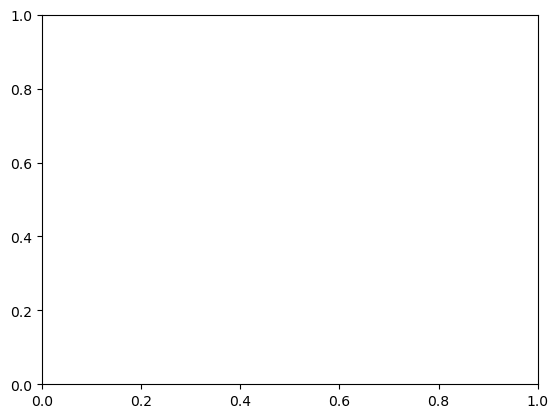

In [378]:
models = [{"label": "Model_GB", "model": rf_boruta}]

# Plot roc curve
plot_curve_functions_feature(models, selected_feature_train_x, feature_train_y)

Gradient Boosting (Features)

In [379]:
param_GB = {
    "n_estimators": 100,
    "criterion": "friedman_mse",
    "learning_rate": 0.1,
    "max_depth": 1,
    "random_state": 42
}
model_GB_feature = GradientBoostingClassifier(**param_GB)

Accuracy: 0.95122
Sensitivity: 0.93443
Specificity: 1.00000
AUC: 0.98595
Confusion Matrix: [[21  0]
 [ 4 57]]


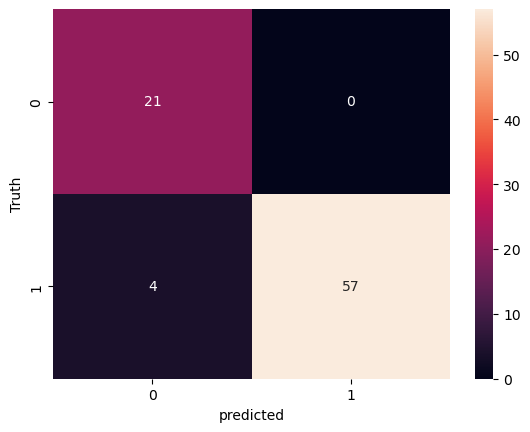

In [380]:
performance_measures = model_training_and_validation(model_GB_feature, "GB", splits)

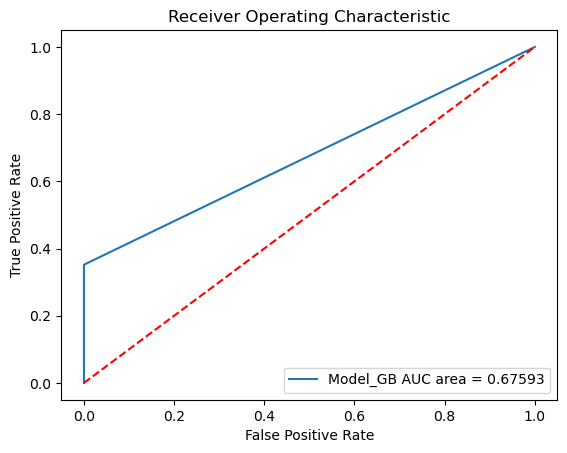

In [381]:
models = [{"label": "Model_GB", "model": model_GB_feature}]

# Plot roc curve
plot_curve_functions(models, feature_test_x, feature_test_y)

In [382]:
feature_importance_GB = pd.Series(model_GB_feature.feature_importances_, index=rdkit_gpr6.columns).sort_values(ascending=False)
feature_importance_GB.head(10)

FractionCSP3    0.848520
SMR_VSA10       0.072119
SlogP_VSA8      0.030608
SMR_VSA5        0.013809
PEOE_VSA11      0.009877
EState_VSA4     0.004624
SMR_VSA6        0.004580
PEOE_VSA8       0.004010
EState_VSA2     0.001916
SlogP_VSA5      0.001790
dtype: float64

XGBoost

In [383]:
import xgboost as xgb

In [384]:
model_XGB_feature = xgb.XGBClassifier(objective='binary:logistic')

Accuracy: 0.97561
Sensitivity: 0.96721
Specificity: 1.00000
AUC: 0.98517
Confusion Matrix: [[21  0]
 [ 2 59]]


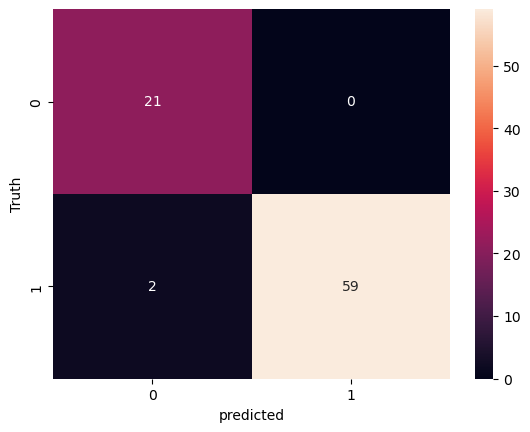

In [385]:
performance_measures = model_training_and_validation_feature(model_XGB_feature, "XGB", splits)

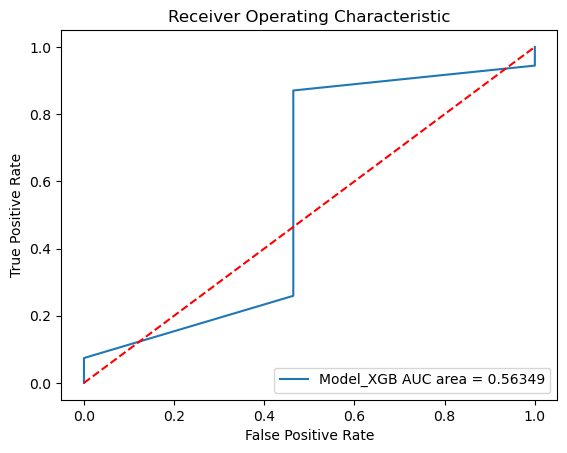

In [386]:
models = [{"label": "Model_XGB", "model": model_XGB_feature}]

# Plot roc curve
plot_curve_functions_feature(models, feature_test_x, feature_test_y)

Hyperparameter Searching

In [387]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [388]:
#model_XGB = xgb.XGBClassifier()
#
#params = {"colsample_bytree": uniform(0.7, 0.3),
#             "gamma": uniform(0, 0.5),
#             "learning_rate": uniform(0.03, 0.3), # default 0.1 
#             "max_depth": randint(2, 6), # default 3
#             "n_estimators": randint(100, 150), # default 100
#             "subsample": uniform(0.6, 0.4)
#}
#
#search = RandomizedSearchCV(model_XGB, param_distributions=params, 
#                            n_iter=100, cv=3, verbose=1, n_jobs=1, return_train_score=True)
#
#search.fit(feature_train_x, feature_train_y)
#
#report_best_scores(search.cv_results_, 3)

In [389]:
param_xgb = {"colsample_bytree": 0.9,
          "gamma": 0.2,
          "learning_rate": 0.2, # default 0.1 
          "max_depth": 3, # default 3
          "n_estimators": 120, # default 100
          "subsample": 0.7,
          "random_state": 42
}

model_XGB = xgb.XGBClassifier(**param_xgb)

Accuracy: 0.97561
Sensitivity: 0.96721
Specificity: 1.00000
AUC: 0.98283
Confusion Matrix: [[21  0]
 [ 2 59]]


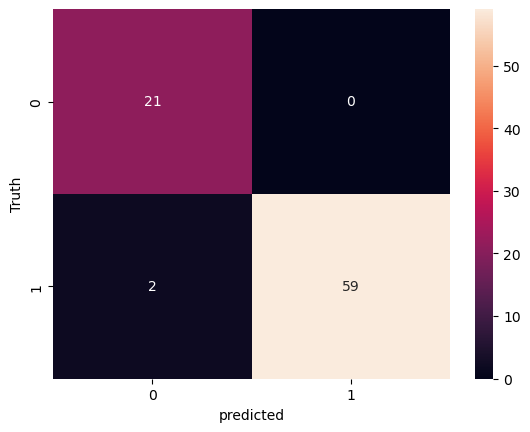

In [390]:
performance_measures = model_training_and_validation_feature(model_XGB, "XGB", splits)

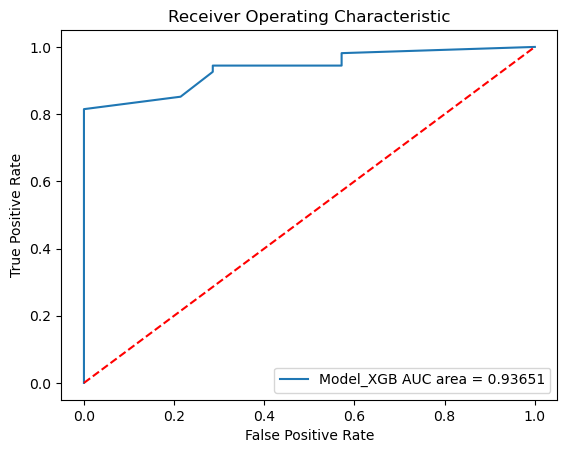

In [391]:
models = [{"label": "Model_XGB", "model": model_XGB}]

# Plot roc curve
plot_curve_functions_feature(models, feature_test_x, feature_test_y)

In [392]:
! pip install graphviz

In [393]:
#import graphviz
#
#xgb.plot_importance(model_XGB)
#
#xgb.to_graphviz(model_XGB, num_trees=model_XGB.best_iteration)